In [11]:
import math
import numpy as np
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit import IBMQ
import matplotlib
%matplotlib inline

IBMQ.load_account()

C:\Users\Sorin\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [12]:
def getStatevectorFromImage(path):
    from PIL import Image
    image= Image.open(path)
    (width, height) = image.size
    pixels = image.load()

    ssum = 0
    for i in range(width):
        for j in range(height):
            ssum += pixels[i,j]**2

    m = math.floor(math.log(height, 2))
    n = math.floor(math.log(width, 2))
    stateVector = np.zeros(2**(m+n))
    for i in range(width):
        for j in range(height):
            stateVector[i*height + j] = pixels[i,j]/math.sqrt(ssum)
            
    return stateVector, m, n

In [13]:
def exportQuantumImage(counts, shots, height, width):
    from PIL import Image

    r = math.floor(math.log(width, 2))
    img= Image.new("L", (width, height))
    pixels = img.load()

    maxAmplitude = 256
    medAmplitude = maxAmplitude/2
    med = shots/(height * width)
    for key in counts:
        i = int(key[0:r], 2)
        j = int(key[r:], 2)
        val = round((((counts[key] - med)/med)*medAmplitude) + medAmplitude)
        pixels[i,j] = (val)
        
    return img

In [14]:
def Translate(increment, quantumRegister, circuit):
    from qiskit.aqua.components.qfts import Standard as qft
    from qiskit.aqua.components.iqfts import Standard as iqft
    
    n = len(quantumRegister)
    
    qft(n).construct_circuit(qubits=quantumRegister,circuit=circuit)
    
    for j in range(n):
        circuit.u1((np.pi*increment)/(2**(n-1-j)), quantumRegister[j])
        
    iqft(n).construct_circuit(qubits=quantumRegister,circuit=circuit)
    

In [15]:
def Rotate(rowReg, columnReg, circuit):
    circuit.x(rowReg)
    circuit.x(columnReg)

In [16]:
def Transpose(rowReg, columnReg, circuit):
    m = rowReg.size
    n = columnReg.size
    
    if (n != m):
        raise "Can only transpose square images" 
    
    for i in range(n):
        circuit.swap(rowReg[i], columnReg[i])

In [17]:
from qiskit.aqua.components.qfts import Standard as qft
stateVector, m, n = getStatevectorFromImage('document.bmp')

state = [complex(x) for x in stateVector]
indexes = range(m+n)

columnReg = QuantumRegister(n)
rowReg = QuantumRegister(m)
creg = ClassicalRegister(n+m)

circ = QuantumCircuit(rowReg, columnReg, creg)
circ.initialize(state, indexes)

qft(m).construct_circuit(qubits=rowReg,circuit=circ)
qft(n).construct_circuit(qubits=columnReg,circuit=circ)

Translate(2**(n-1), rowReg, circ)
Translate(2**(m-1), columnReg, circ)
circ.measure(indexes, indexes)

provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_qasm_simulator')

shots = 1024
result = execute(circ, localSimulator, shots=shots).result()
counts = result.get_counts(circ)

In [21]:
sortedCounts = sorted(counts.items(), key=lambda kv: kv[1])
sortedCounts.reverse()
mappedSortedCounts = [((int(c[0][0:n], 2), int(c[0][n:], 2)), c[1]) for c in sortedCounts]
minOffset = 2**(m-2)

def hasMinimumOffset(point1, point2, minOffset):
    colDif = np.abs(point1[0] - point2[0])
    if (colDif >= minOffset):
        return True
    lineDif = np.abs(point1[1] - point2[1])
    if (lineDif >= minOffset):
        return True
    return False

def computeAngle(point1, point2):
    dx = np.abs(point1[1] - point2[1])
    dy = np.abs(point1[0] - point2[0])
    angle = np.arctan2(dy, dx)
    return np.rad2deg(angle)

angles = {}
used = []
rng = min(50, len(mappedSortedCounts)-1)
for i in range(rng):
    point1 = mappedSortedCounts[i][0]
    if (point1 in used):
        continue
    used.append(point1)
    for p2 in mappedSortedCounts[i+1:]:
        point2 = p2[0]
        if (point2 in used):
            continue
        if (hasMinimumOffset(point1, point2, minOffset)):
            used.append(point2)
            angle = np.round(computeAngle(point1, point2))
            angles[angle] = angles.get(angle, 0) + 1
            break

sortedAngles = sorted(angles.items(), key=lambda kv: kv[1])
sortedAngles.reverse()
sortedAngles[0]   

(29.0, 3)

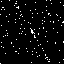

In [19]:
exportQuantumImage(counts, shots, 2**m, 2**n)